# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. The dataset includes IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

## Initialization

In [144]:
import numpy as np
import pandas as pd

In [145]:
print(np.__version__)

1.21.2


In [146]:
# was runnign np version 2.02 and getting error so downgrading version
#pip install "numpy<2"

In [147]:
import math

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm



In [148]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

#plt.style.use("seaborn-v0_8")

In [149]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [150]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [151]:
#df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [152]:
df_reviews.head(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [153]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [154]:
# check for missing values

df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [155]:
df_reviews.duplicated().sum()

0

In [156]:
df_reviews['pos'].value_counts()

# no class imabalance

0    23715
1    23616
Name: pos, dtype: int64

## EDA

Look at the number of movies and reviews over years.

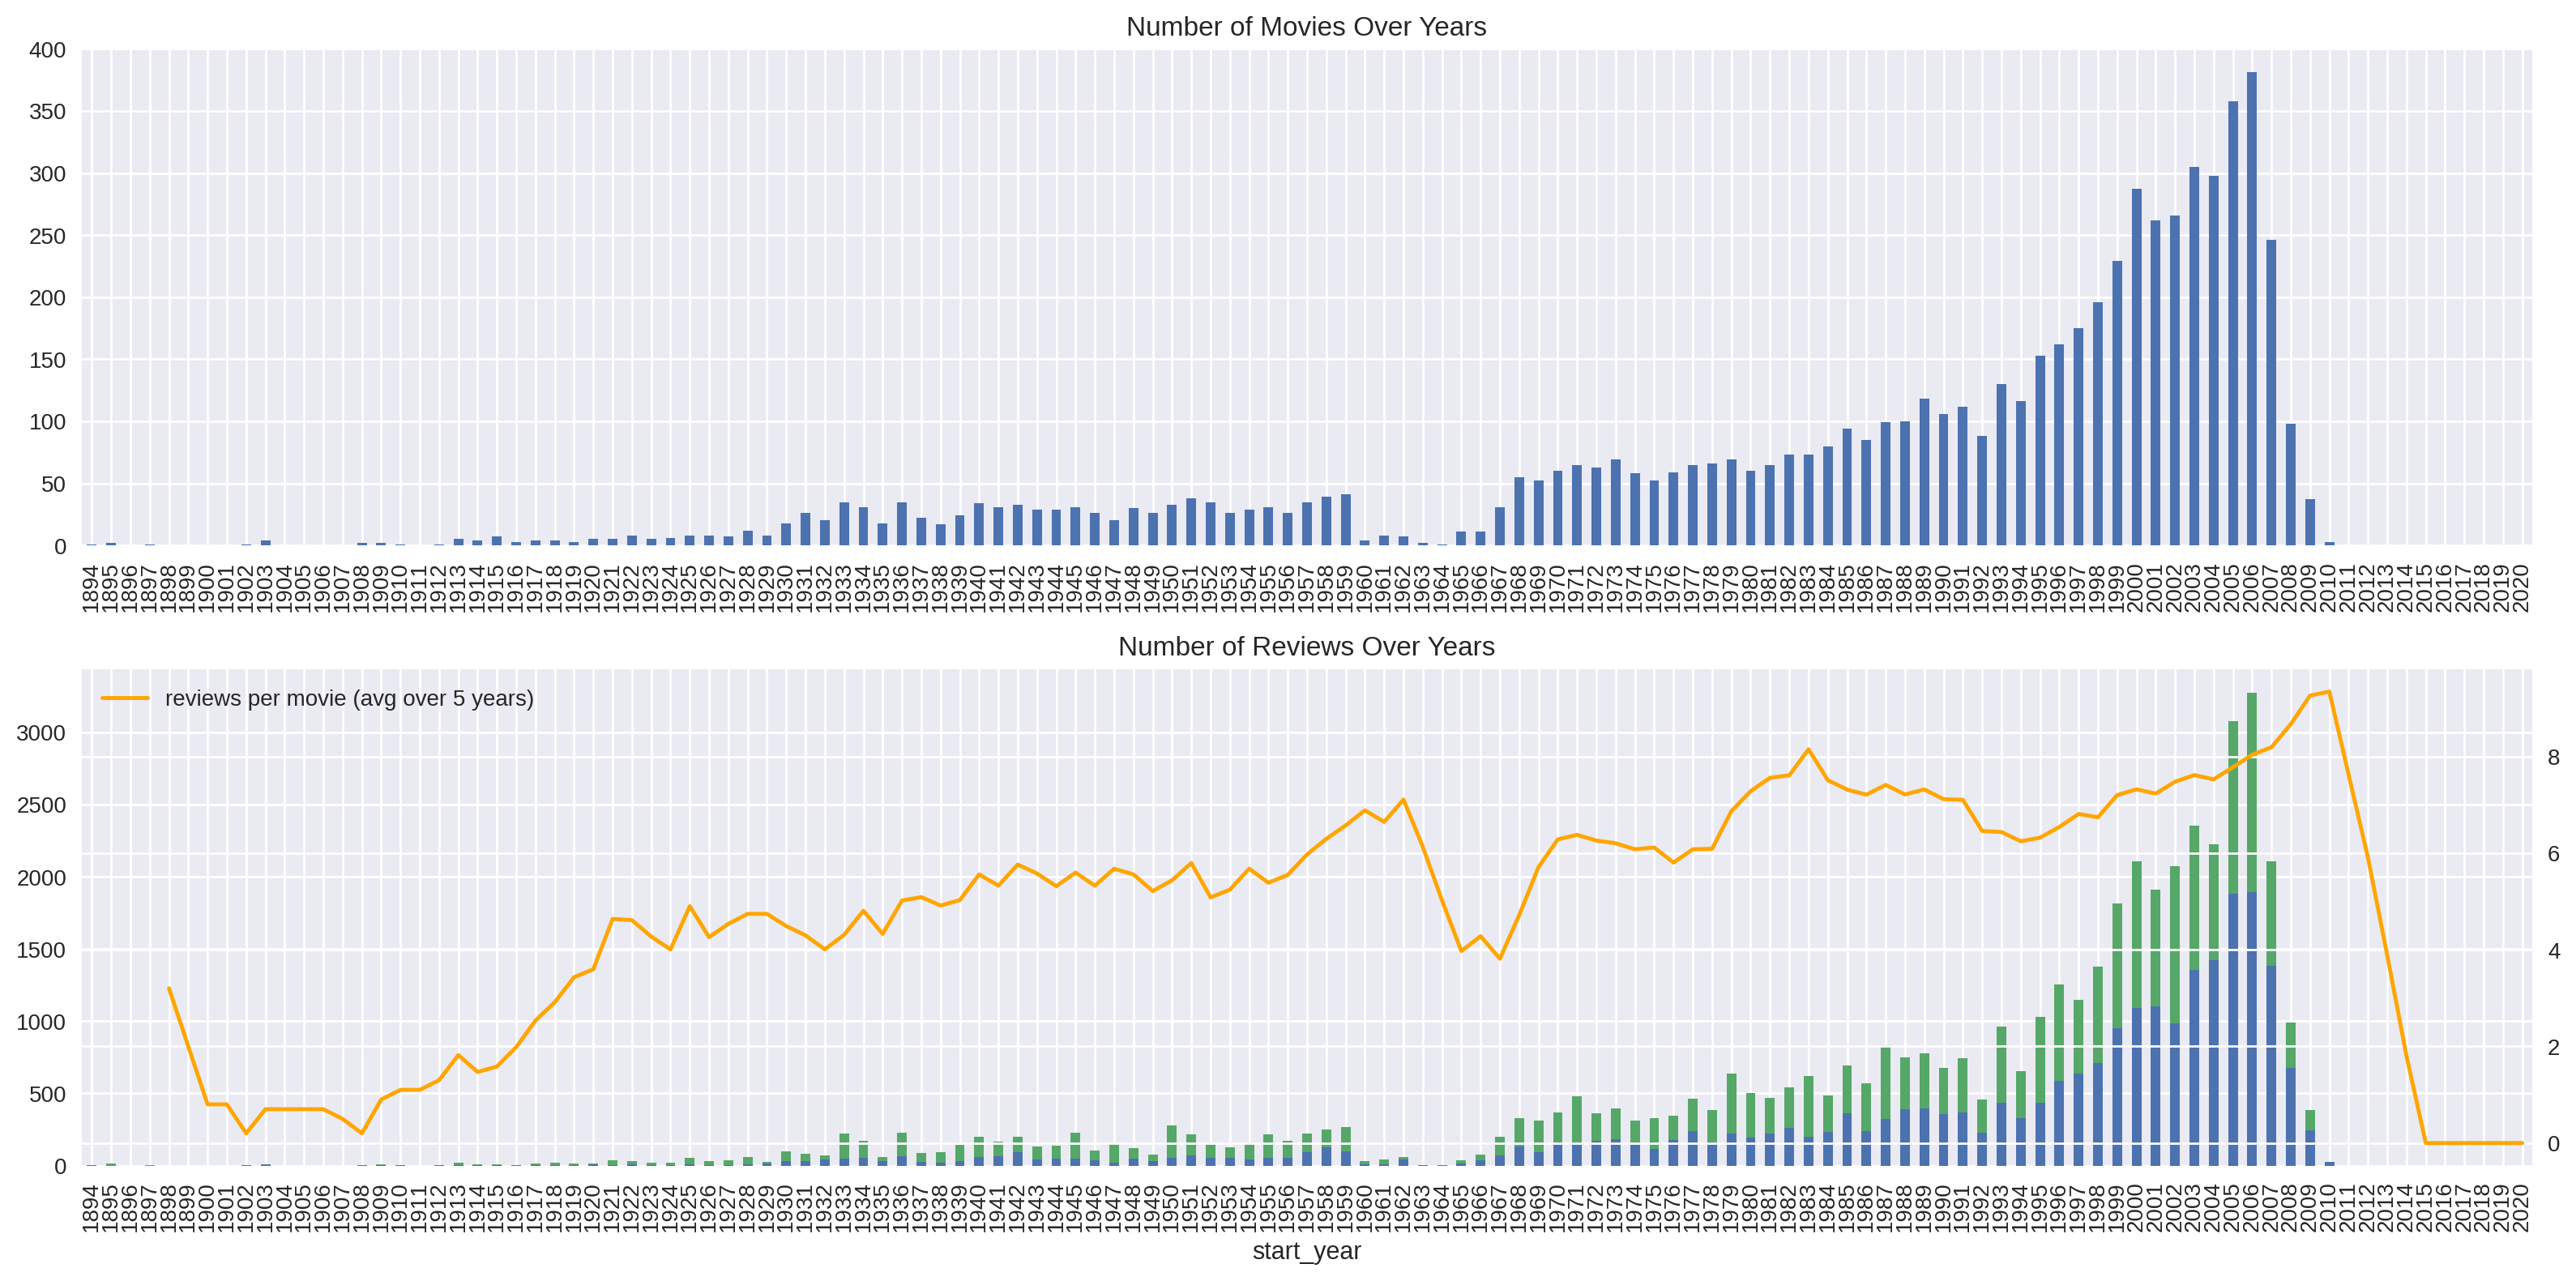

In [157]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()
plt.show()

This chart shows how many movies were made each year from 1884 to 2020. Movie production started slowly, with a small increase in the 1930s. There was a big jump in the number of movies made from the 1970s, reaching a peak around 2006–2007. After that, the number of movies dropped sharply, possibly because of missing data or changes in the industry. 

Check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

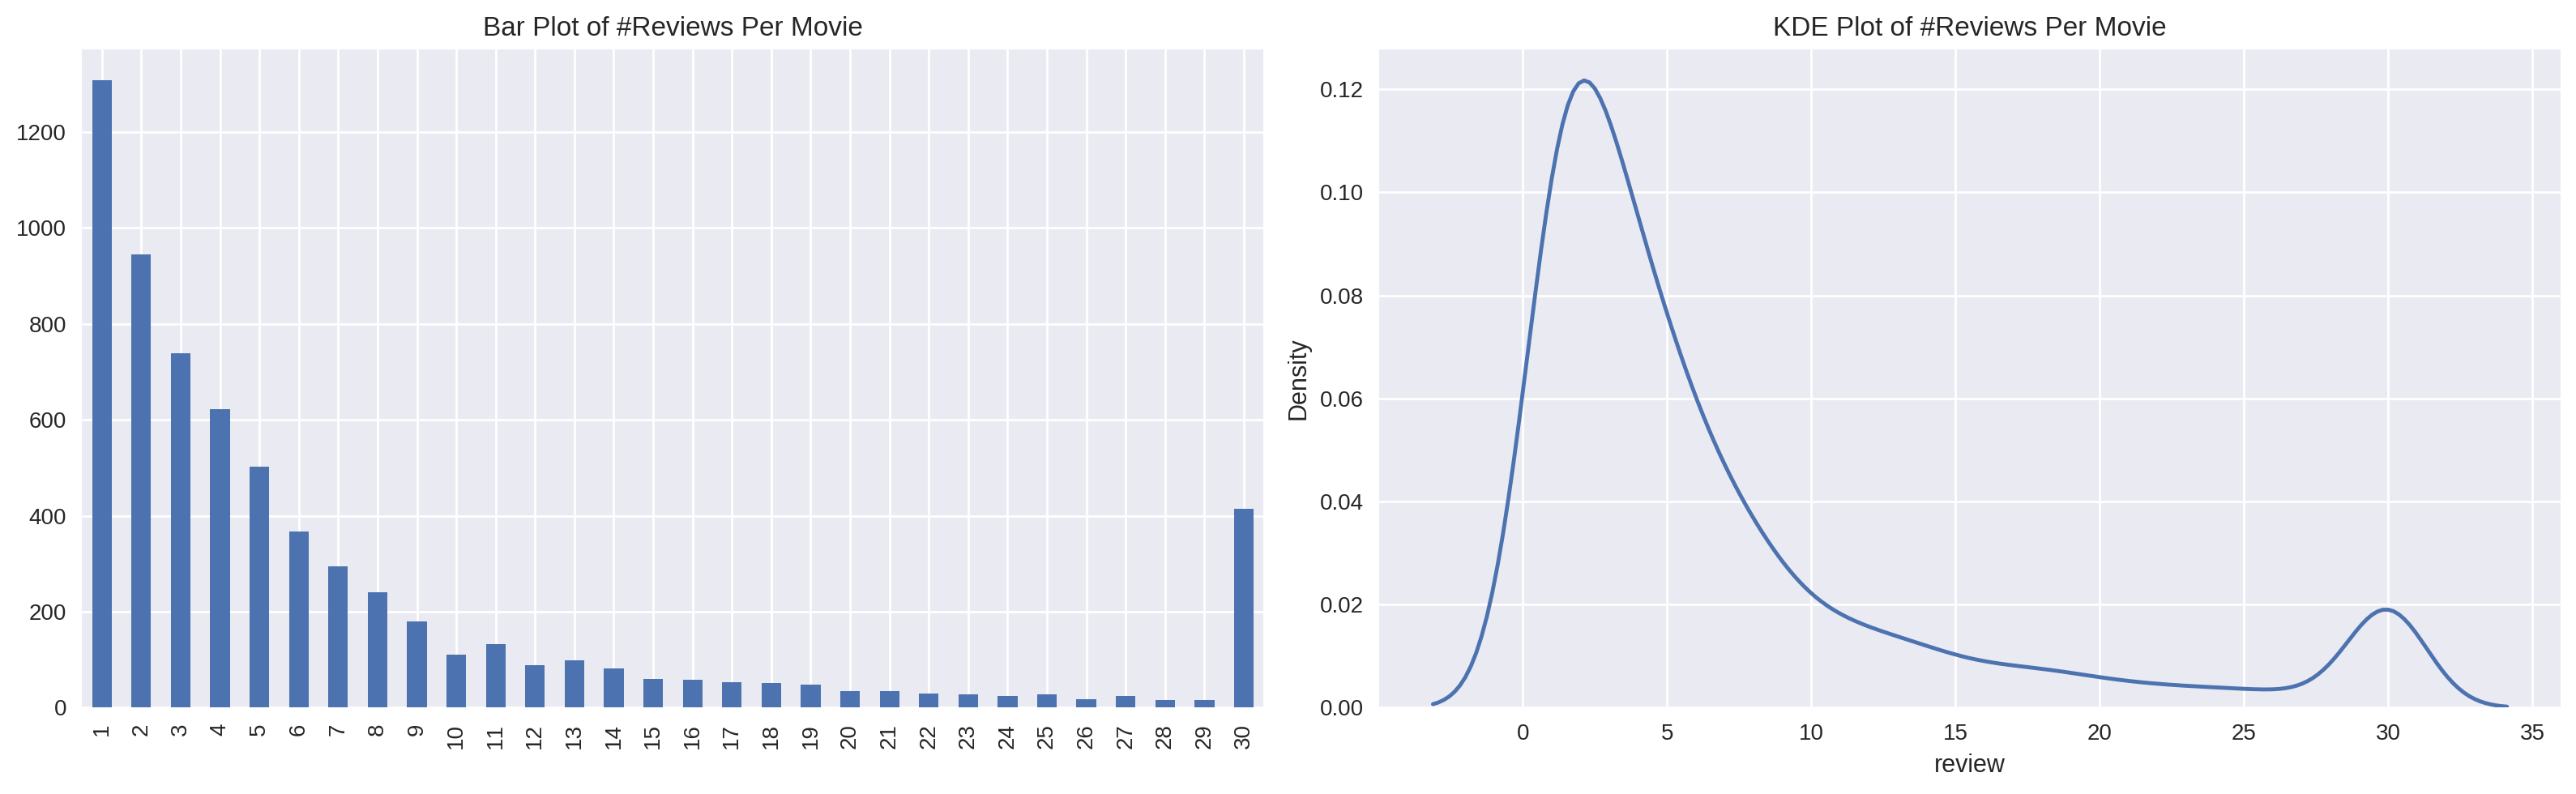

In [158]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()
plt.show()

These plots show how many reviews movies received:

* The bar plot shows that most movies have only a few reviews. One review is the most common, and the number of movies drops as the number of reviews increases. There’s a small spike at 30 reviews. 
- The KDE plot shows that most movies cluster around 2–3 reviews, and very few have more than 10. There’s also a second small bump near 30, confirming that some movies consistently hit that review cap.


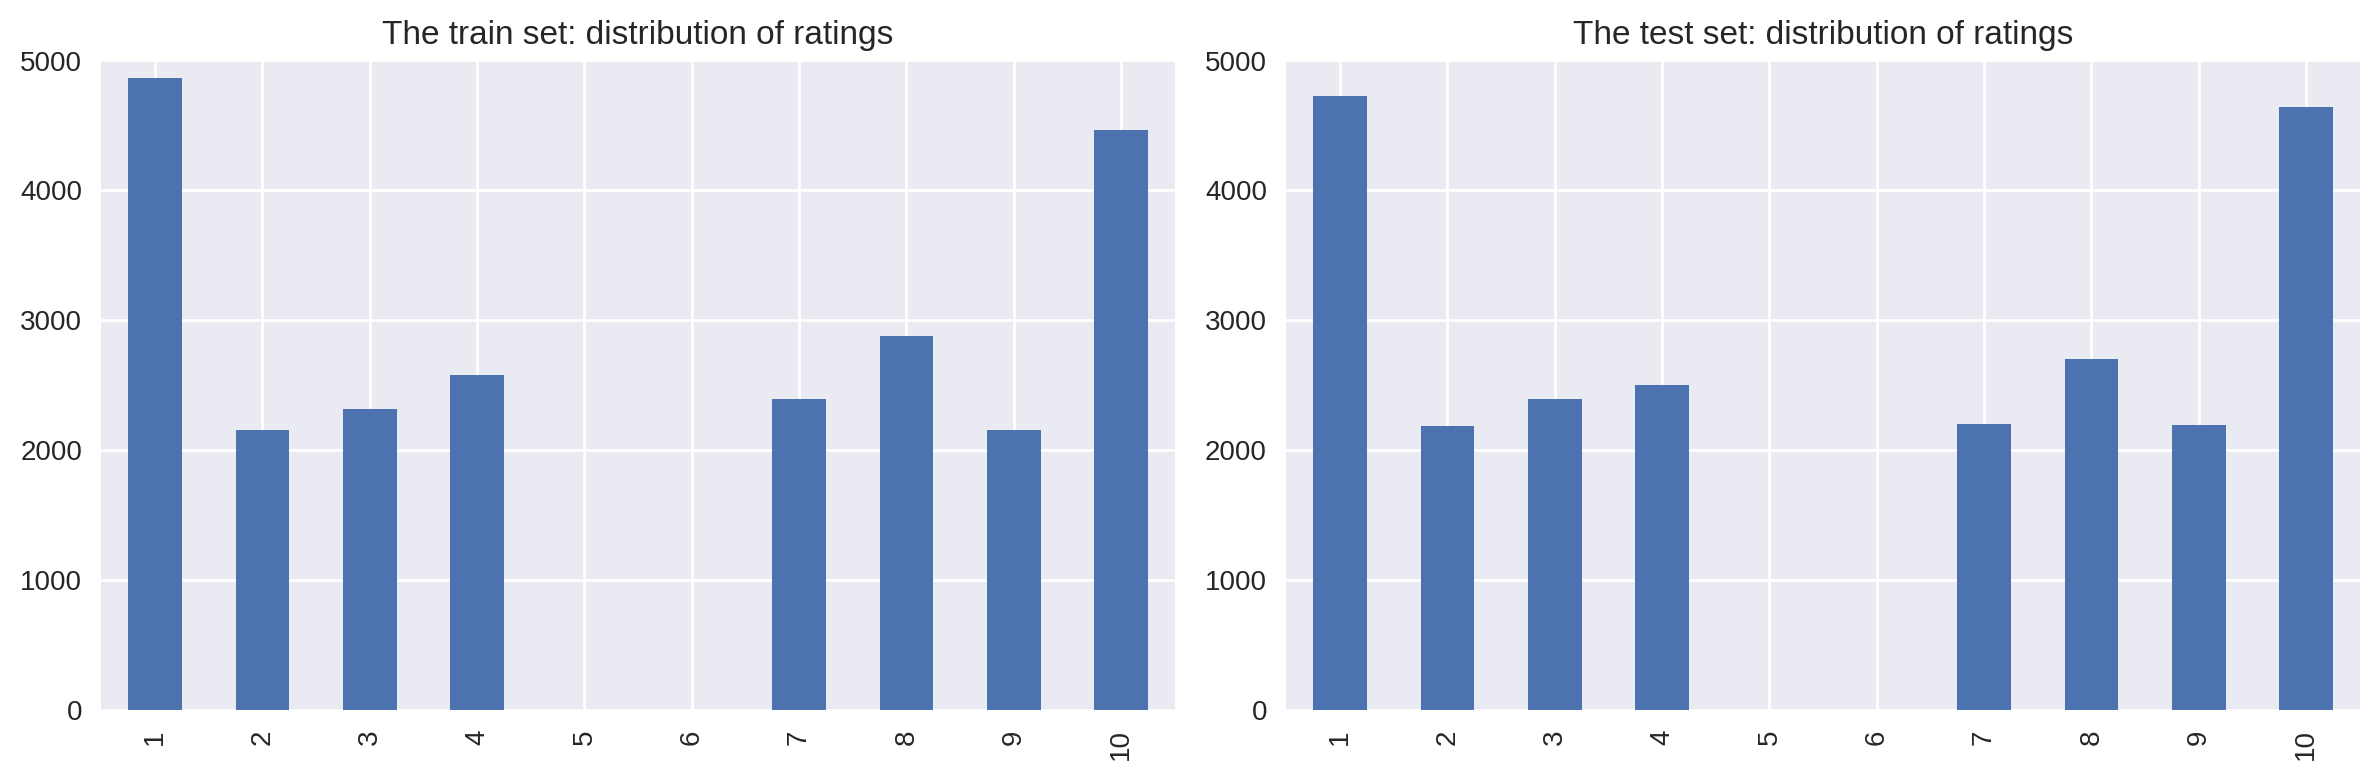

In [159]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()
plt.show()

These bar charts show the distribution of movie ratings in the train and test sets. Both sets have a similar distribution, which is good for model evaluation.

The most common ratings are at the low end (e.g., 1 star) and high end (e.g., 10 stars).

Middle ratings are less frequent, with a dip around the 5–7 range.

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


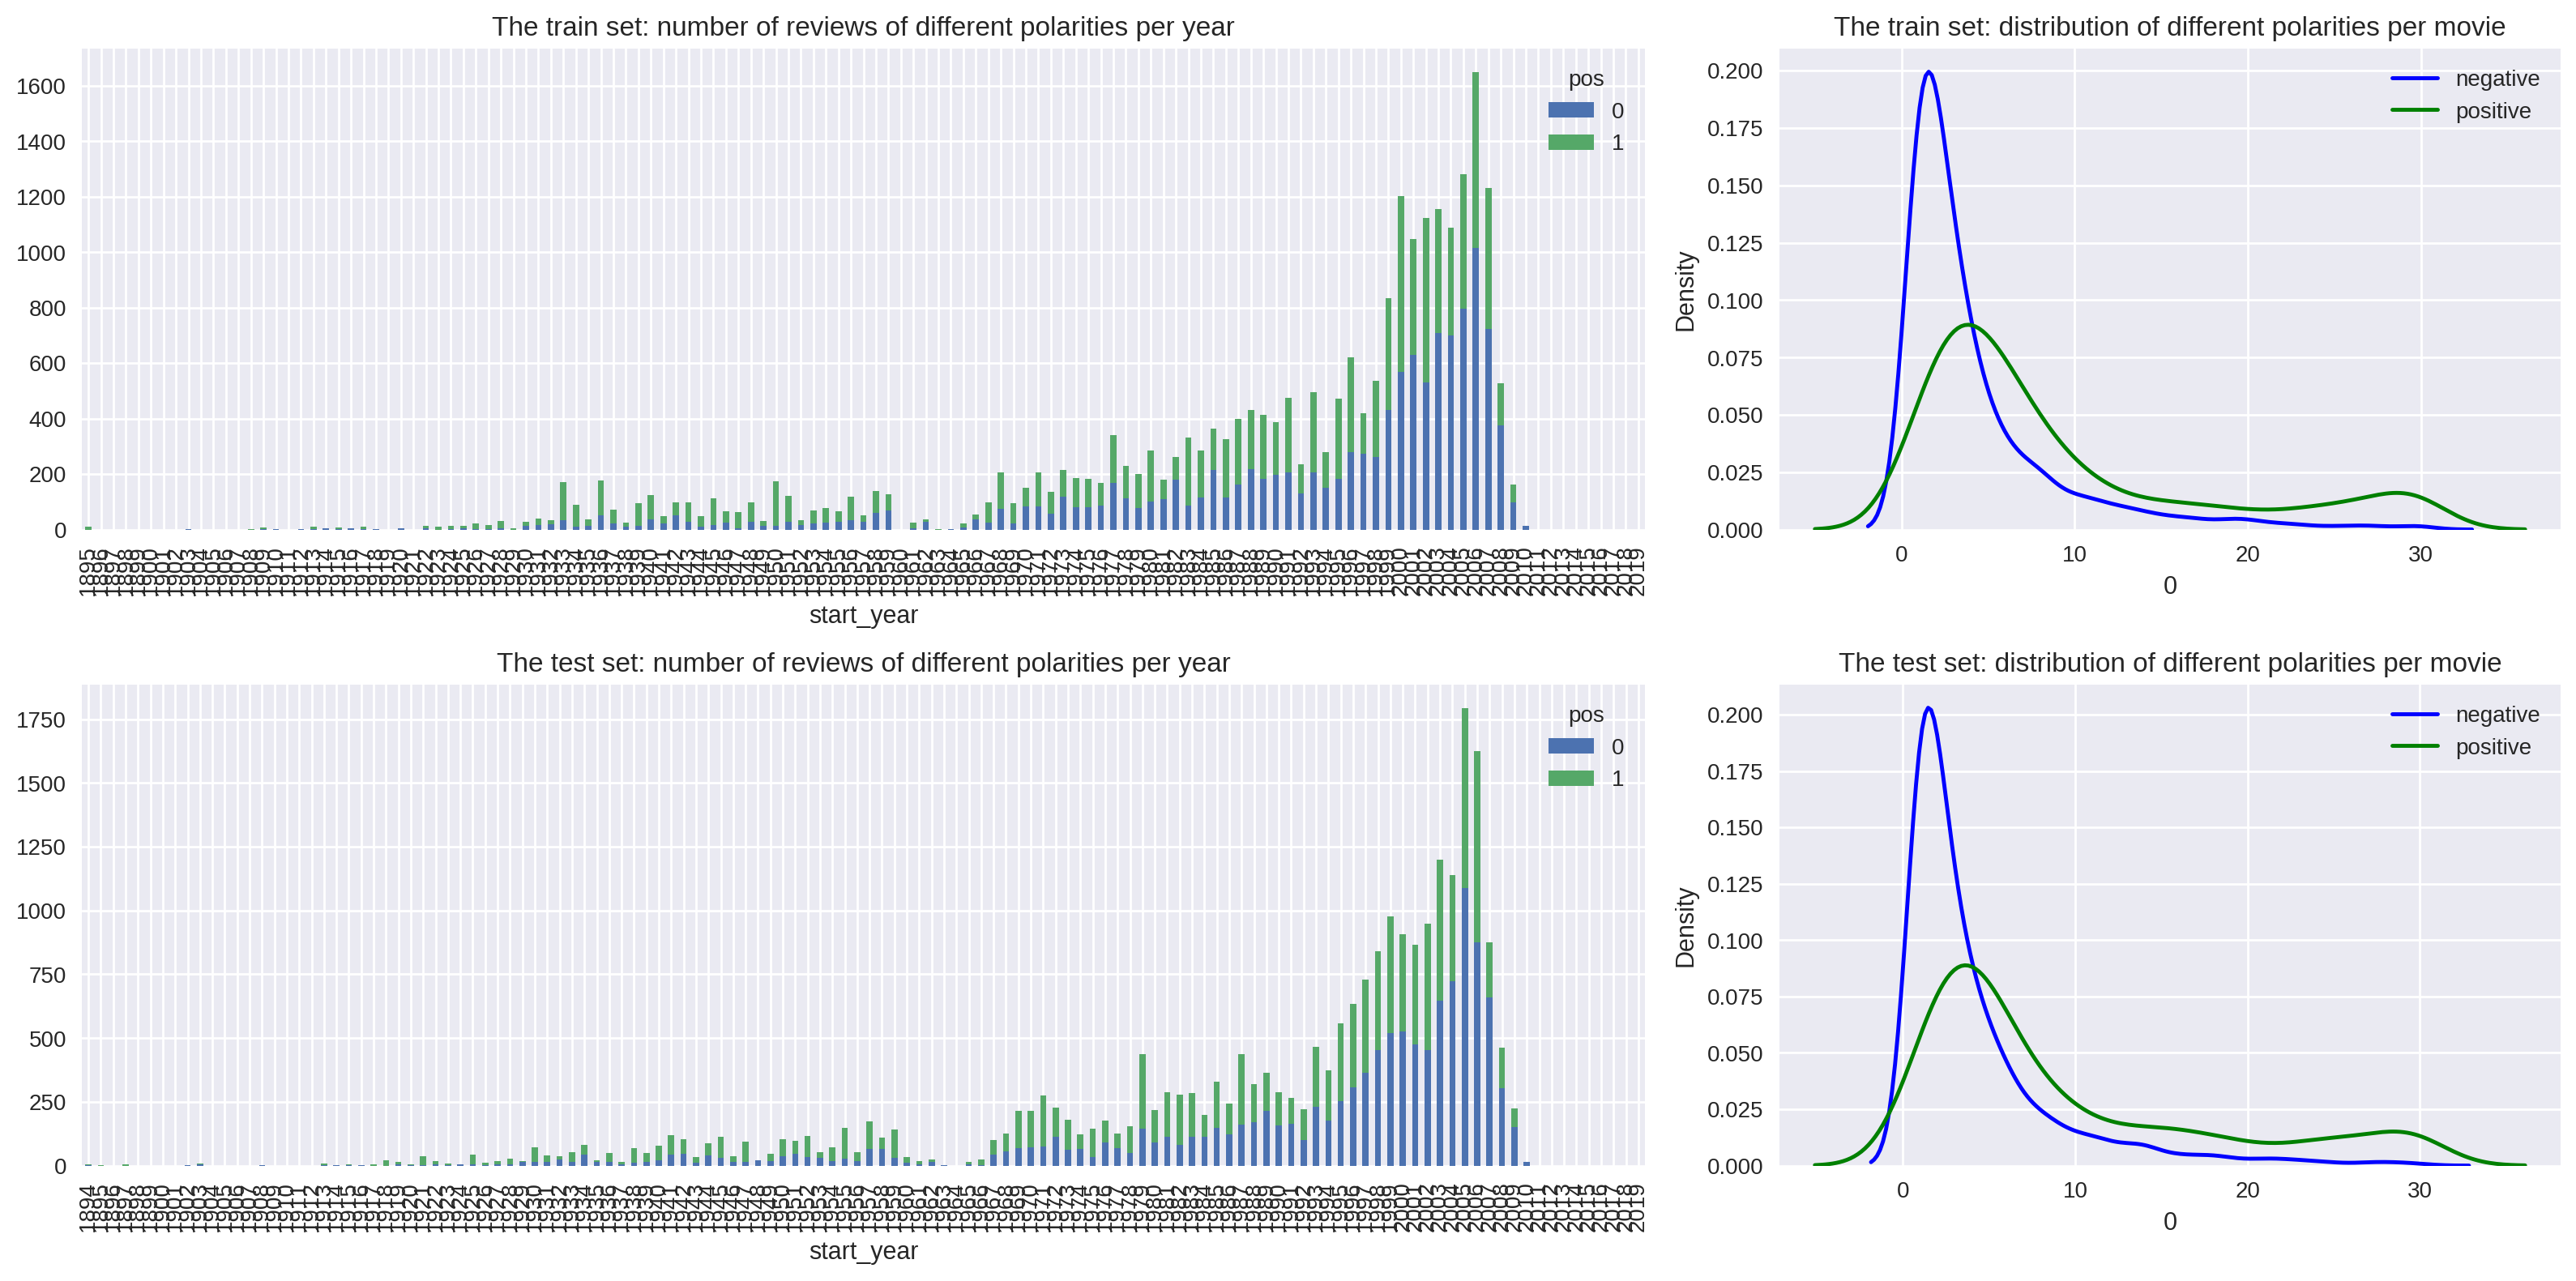

In [160]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()
plt.show()

These plots show the distribution of positive (green) and negative (blue) reviews in the test set over time and per movie:

* The left plot shows the number of reviews by year: Here, both positive and negative reviews increase over time. Positive reviews generally outnumber negative ones in recent years.

* The right plot shows the distribution of review polarity per movie: Most movies have only a few reviews, with negative reviews (blue) peaking at 1–2. Positive reviews (green) are more spread out and slightly more common at higher counts.


## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [161]:
import sklearn.metrics as metrics
# Plots F1, ROC-AUC Curve and PRC Curve for training and test sets.

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [162]:
import re

# Convert to lowercase and remove all characters except letters, apostrophes, and spaces
def normalize_text(text):
    return text.apply(lambda row: ' '.join
                      (re.sub(r"[^a-zA-Z']", ' ', row.lower()).split() 
                                          ))


In [163]:


# Convert to lowercase and remove all characters except letters, apostrophes, and spaces
#def normalize_text(text):
    #text_cleaned = []
    #for row in text:
        #cleaned = row.lower()
        #cleaned = re.sub(r"[^a-zA-Z']", " ", cleaned) # removes and replaces anything that is not a letter or an apostrophe
        #cleaned = cleaned.split() # split() method to convert string into a list without spaces  
        #cleaned = ' '.join(cleaned) # recombine elements into a string with spaces
        #text_cleaned.append(cleaned)
   # return text_cleaned

In [164]:
df_reviews['review_norm'] = normalize_text(df_reviews['review'])

In [165]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

In [166]:
df_reviews.columns

Index(['tconst', 'title_type', 'primary_title', 'original_title', 'start_year',
       'end_year', 'runtime_minutes', 'is_adult', 'genres', 'average_rating',
       'votes', 'review', 'rating', 'sp', 'pos', 'ds_part', 'idx',
       'review_norm'],
      dtype='object')

## Train / Test Split

The whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [167]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

#Features
train_features= df_reviews_train['review_norm']
test_features=  df_reviews_test['review_norm']

#Target
train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print("Train set shape:", df_reviews_train.shape)
print("Test set shape:",df_reviews_test.shape)
print()
print("Train features shape:",train_features.shape)
print("Train target shape:",train_target.shape)
print()
print("Test features shape:",test_features.shape)
print("Test target shape:", test_target.shape)

Train set shape: (23796, 18)
Test set shape: (23535, 18)

Train features shape: (23796,)
Train target shape: (23796,)

Test features shape: (23535,)
Test target shape: (23535,)


## Working with models

### Model 0 - Constant

In [168]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


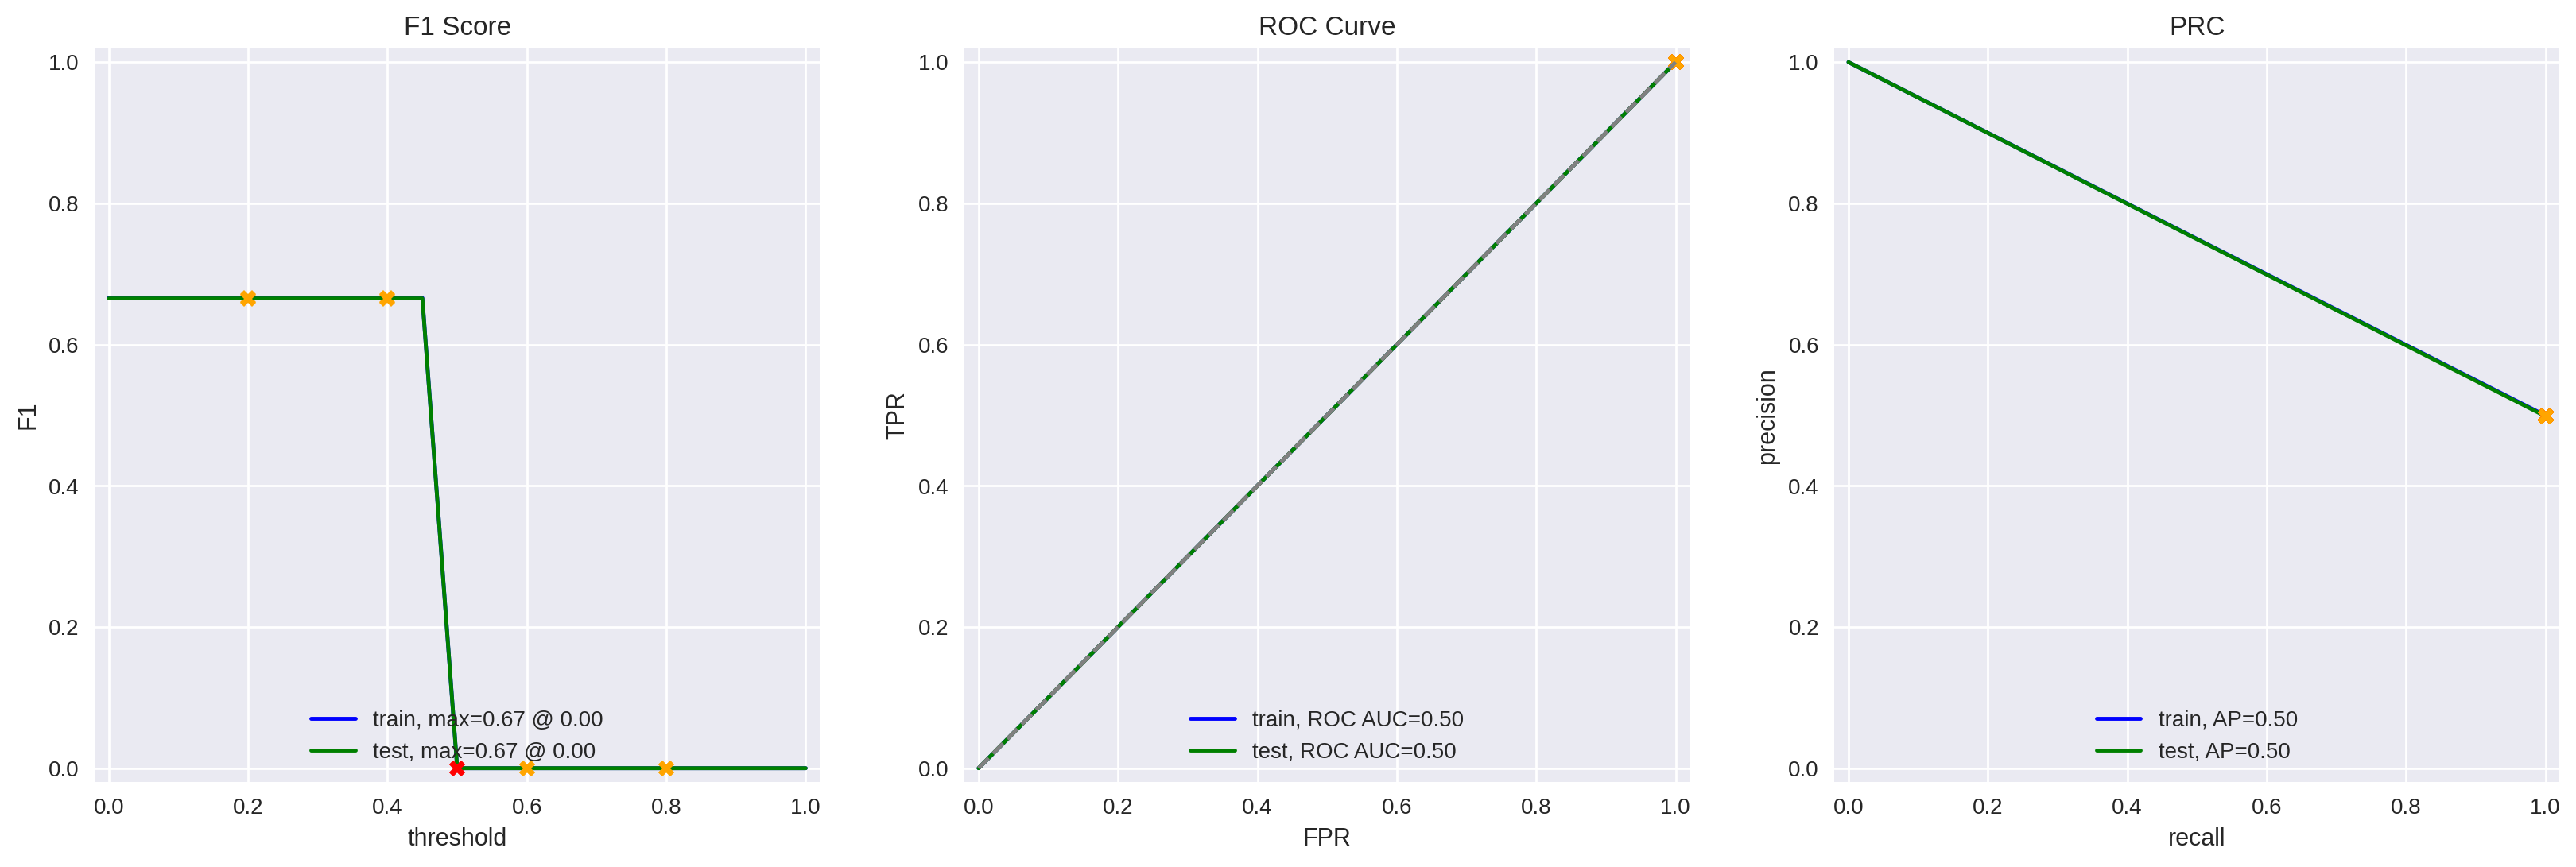

In [169]:

dummy_clf = DummyClassifier(random_state=0)
dummy_clf.fit(train_features, train_target)

evaluate_model(dummy_clf, train_features, train_target, test_features, test_target)


<div class="alert alert-success">
<b>Reviewer's comment V1</b>

Correct

</div>

### Model 1 - NLTK, TF-IDF and LR

**NLTK**

tokenization and lemmatization

In [170]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [171]:
#downlaoded for stopwords to run
#nltk.download('punkt_tab')
#nltk.download('wordnet')
#nltk.download('stopwords')

In [172]:
#lemmatizer = WordNetLemmatizer() 

#def text_preprocessing_nltk(text):
  #  review_lemmas = []
  #  for row in text:      
    #    tokens = word_tokenize(row)
     #   lemmas = [lemmatizer.lemmatize(token) for token in tokens]
      #  review_lemmas.append(" ".join(lemmas))
    #return review_lemmas

In [173]:
lemmatizer = WordNetLemmatizer()

def text_preprocessing_nltk(text):
    return text.apply(lambda row: " ".join(
        lemmatizer.lemmatize(token) for token in word_tokenize(row)
    ))

In [174]:
df_reviews_train['review_lemmas_nltk'] = text_preprocessing_nltk(train_features)
df_reviews_test['review_lemmas_nltk'] = text_preprocessing_nltk(test_features)

In [175]:
df_reviews_train

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm,review_lemmas_nltk
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...,how the hell did they get this made presenting...
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903,this true story of carlson's raiders is more o...,this true story of carlson 's raider is more o...
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905,should have been titled 'balderdash ' little i...,should have been titled 'balderdash ' little i...
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904,the movie 'gung ho ' the story of carlson's ma...,the movie 'gung ho ' the story of carlson 's m...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47253,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,O my gosh... Just give me a minute to breath. ...,10,pos,1,train,407,o my gosh just give me a minute to breath this...,o my gosh just give me a minute to breath this...
47254,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,I can't tell you all how much I love this movi...,10,pos,1,train,408,i can't tell you all how much i love this movi...,i ca n't tell you all how much i love this mov...
47255,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,Legend of Zu is possibly the most exciting mov...,10,pos,1,train,409,legend of zu is possibly the most exciting mov...,legend of zu is possibly the most exciting mov...
47256,tt0286098,movie,Zu Warriors,Shu shan zheng zhuan,2001,\N,104,0,"Action,Fantasy",5.2,3324,This movie is well done on so many levels that...,10,pos,1,train,411,this movie is well done on so many levels that...,this movie is well done on so many level that ...


In [176]:
# Remove stopwords
#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))

**TF-IDF**

In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer(stop_words=stop_words)
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
X_train = tfidf.fit_transform(df_reviews_train['review_lemmas_nltk'])
X_test = tfidf.transform(df_reviews_test['review_lemmas_nltk'])

**LR**

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score

lr = LogisticRegression(random_state=0, max_iter=1000)
param_grid = {'C': [0.1, 1, 10, 100, 1000]}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

model_1 = GridSearchCV(lr, param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
model_1.fit(X_train, train_target)

y_pred = model_1.predict(X_test)

print("Best LR parameters:", model_1.best_params_)
print("Best F1 score:", f1_score(test_target, y_pred))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best LR parameters: {'C': 10}
Best F1 score: 0.870157881114658


In [179]:
print(X_train.shape)
print(test_features.shape)
print(X_test.shape)
print(test_target.shape)

(23796, 64299)
(23535,)
(23535, 64299)
(23535,)


          train  test
Accuracy   0.99  0.87
F1         0.99  0.87
APS        1.00  0.94
ROC AUC    1.00  0.95


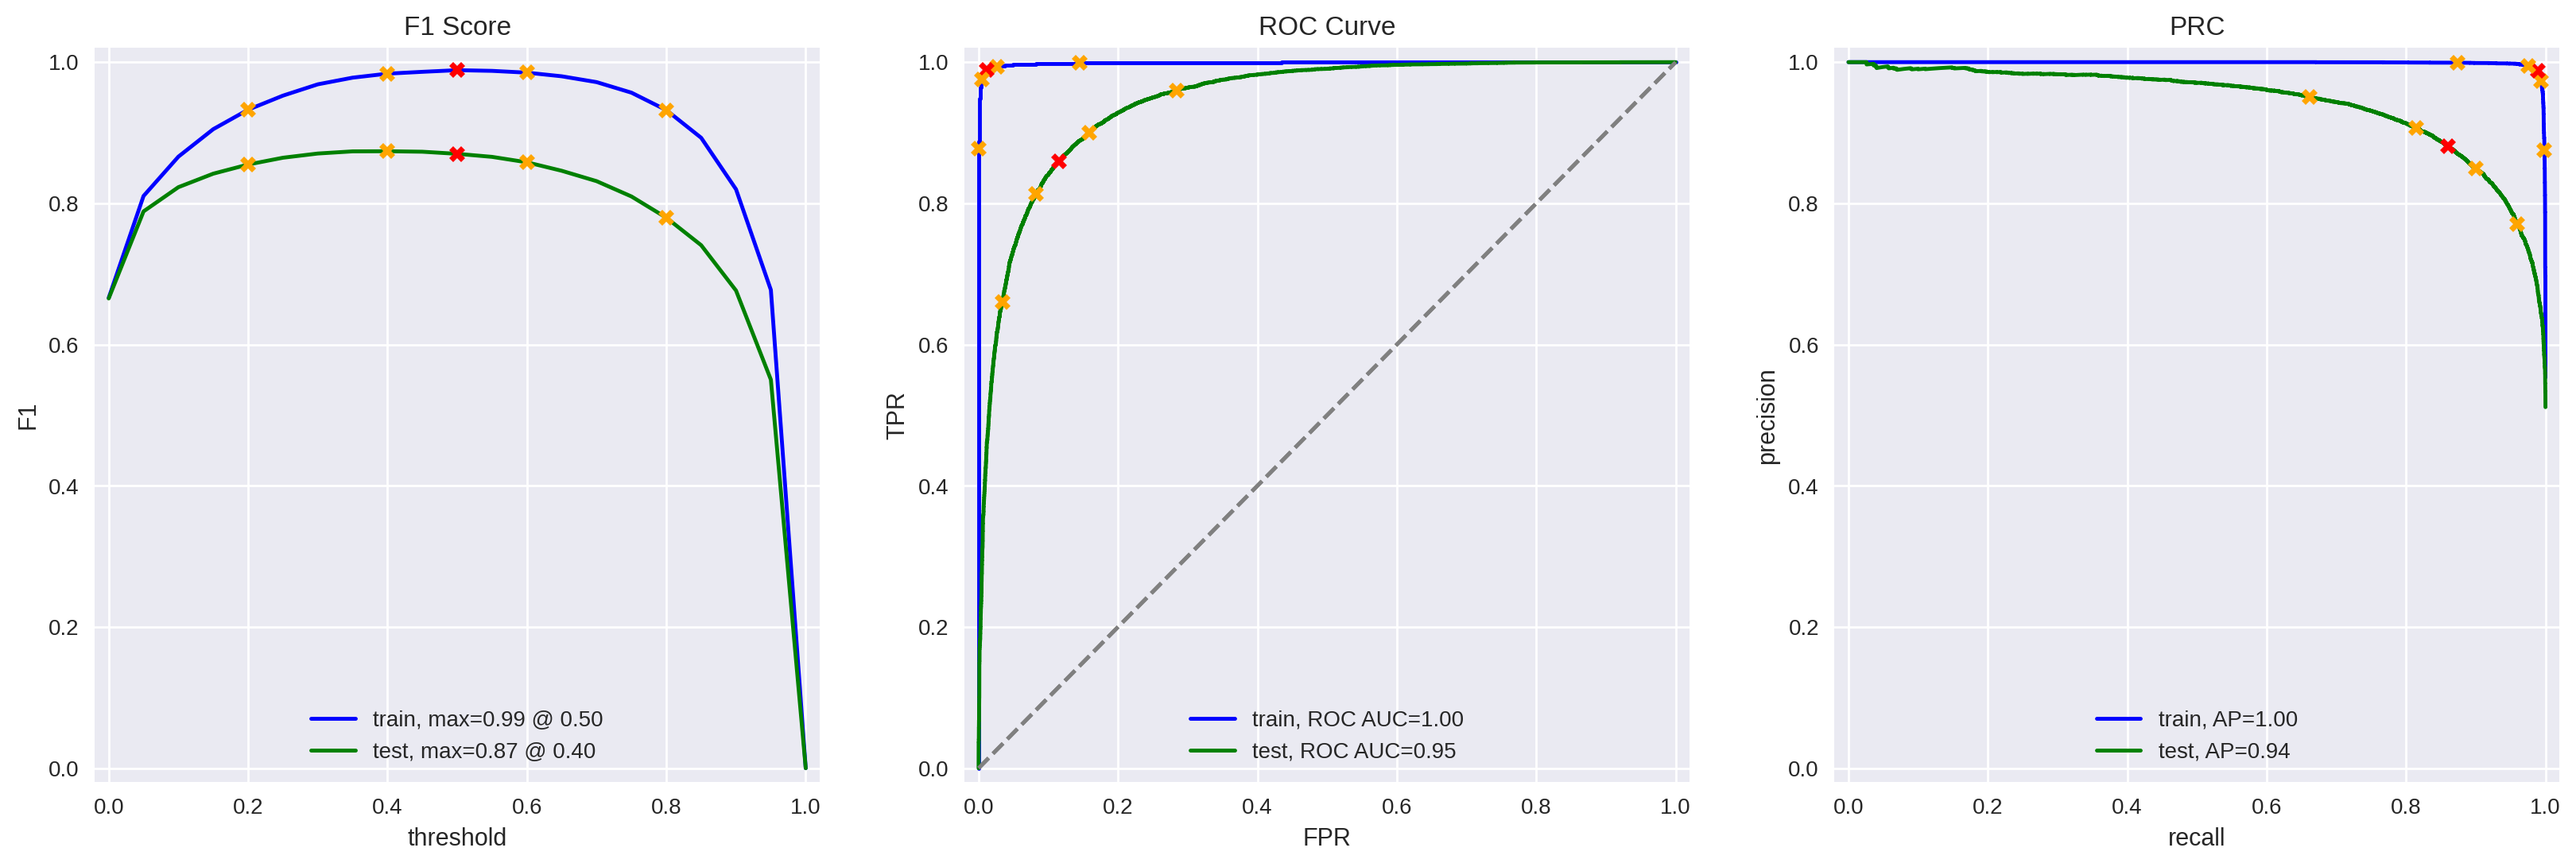

In [180]:
#evaluate_model(model_1, X_train, X_test, test_target)

evaluate_model(model_1, X_train, train_target, X_test, test_target)

### Model 3 - spaCy, TF-IDF and LR

**spaCy**

In [181]:
#pip install spacy

In [182]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

#spacy.cli.download("en_core_web_sm")

In [183]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [184]:
#def text_preprocessing_spacy(text):
    #tokens = []
    #for row in text:

        #doc = nlp(row) #returns list of tokens 

        #lemmas = [token.lemma_ for token in doc if not token.is_stop] #goes through doc and keeps lemmatized
        #lemmas = " ".join(lemmas)
        #tokens.append(lemmas)
    #return tokens

In [185]:
def text_preprocessing_spacy(text):
    return text.apply(lambda row: " ".join(
        token.lemma_ for token in nlp(row) if not token.is_stop
    ))


In [186]:
%%time
df_reviews_train['review_lemmas_spacy'] = text_preprocessing_spacy(train_features)
df_reviews_test['review_lemmas_spacy'] = text_preprocessing_spacy(test_features)

CPU times: user 7min 10s, sys: 0 ns, total: 7min 10s
Wall time: 7min 10s


In [187]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there is no real story the film seems more lik...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teens in sing...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,i'm totally agree with garryjohal from singapo...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038,this is another of my favorite columbos it spo...
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989,talk about being boring i got this expecting a...
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163,i never thought i'd say this about a biopic bu...
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164,spirit and chaos is an artistic biopic of miya...


In [188]:
df_reviews_train.iloc[0]['review_lemmas_spacy']

'pakage imply warren beatty goldie hawn pull huge bank robbery get half new character introduction scene half hour completely incomprehensible rest long annoying underlit chase scene irritate sound background loud watch tick blaring siren train whistle horrible score quincy jones lot part laughably bad like bad guy chase beatty thin ice car police arrive scene roughly time hate movie'

In [189]:
df_reviews_train.iloc[0]['review_lemmas_nltk']

"the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but that 's not what i got out of it i did n't get anything in the first half there 's a new character without introduction in every other scene the first half hour is completely incomprehensible the rest is just one long annoying underlit chase scene there 's always an irritating sound in the background whether it 's a loud watch ticking a blaring siren a train whistling or even the horrible score by quincy jones there are a lot of part that are laughably bad too like the bad guy chasing beatty on thin ice with a car or the police arriving at the scene roughly fifteen time i really hated this movie"

**TF-IDF**

In [190]:
tfidf_3 = TfidfVectorizer(stop_words='english')

X_train = tfidf_3.fit_transform(df_reviews_train['review_lemmas_spacy'])
X_test = tfidf_3.transform(df_reviews_test['review_lemmas_spacy'])
y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']


In [191]:
# new code

# LR with stratified K-Fold and GridsearchCV
parameters = {'C': [0.1, 1, 10, 100, 1000]}
lr_classifier = LogisticRegression(random_state=0, max_iter=1000)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

print("Grid search with Stratified K-Fold...")
model_3 = GridSearchCV(lr_classifier, parameters, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
model_3.fit(X_train, y_train)


print("Best LR parameters:", model_3.best_params_)
y_pred = model_3.predict(X_test)
print("Best LR Accuracy:", f1_score(y_test, y_pred))

Grid search with Stratified K-Fold...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best LR parameters: {'C': 10}
Best LR Accuracy: 0.8612621945955279


          train  test
Accuracy   0.98  0.86
F1         0.98  0.86
APS        1.00  0.94
ROC AUC    1.00  0.94


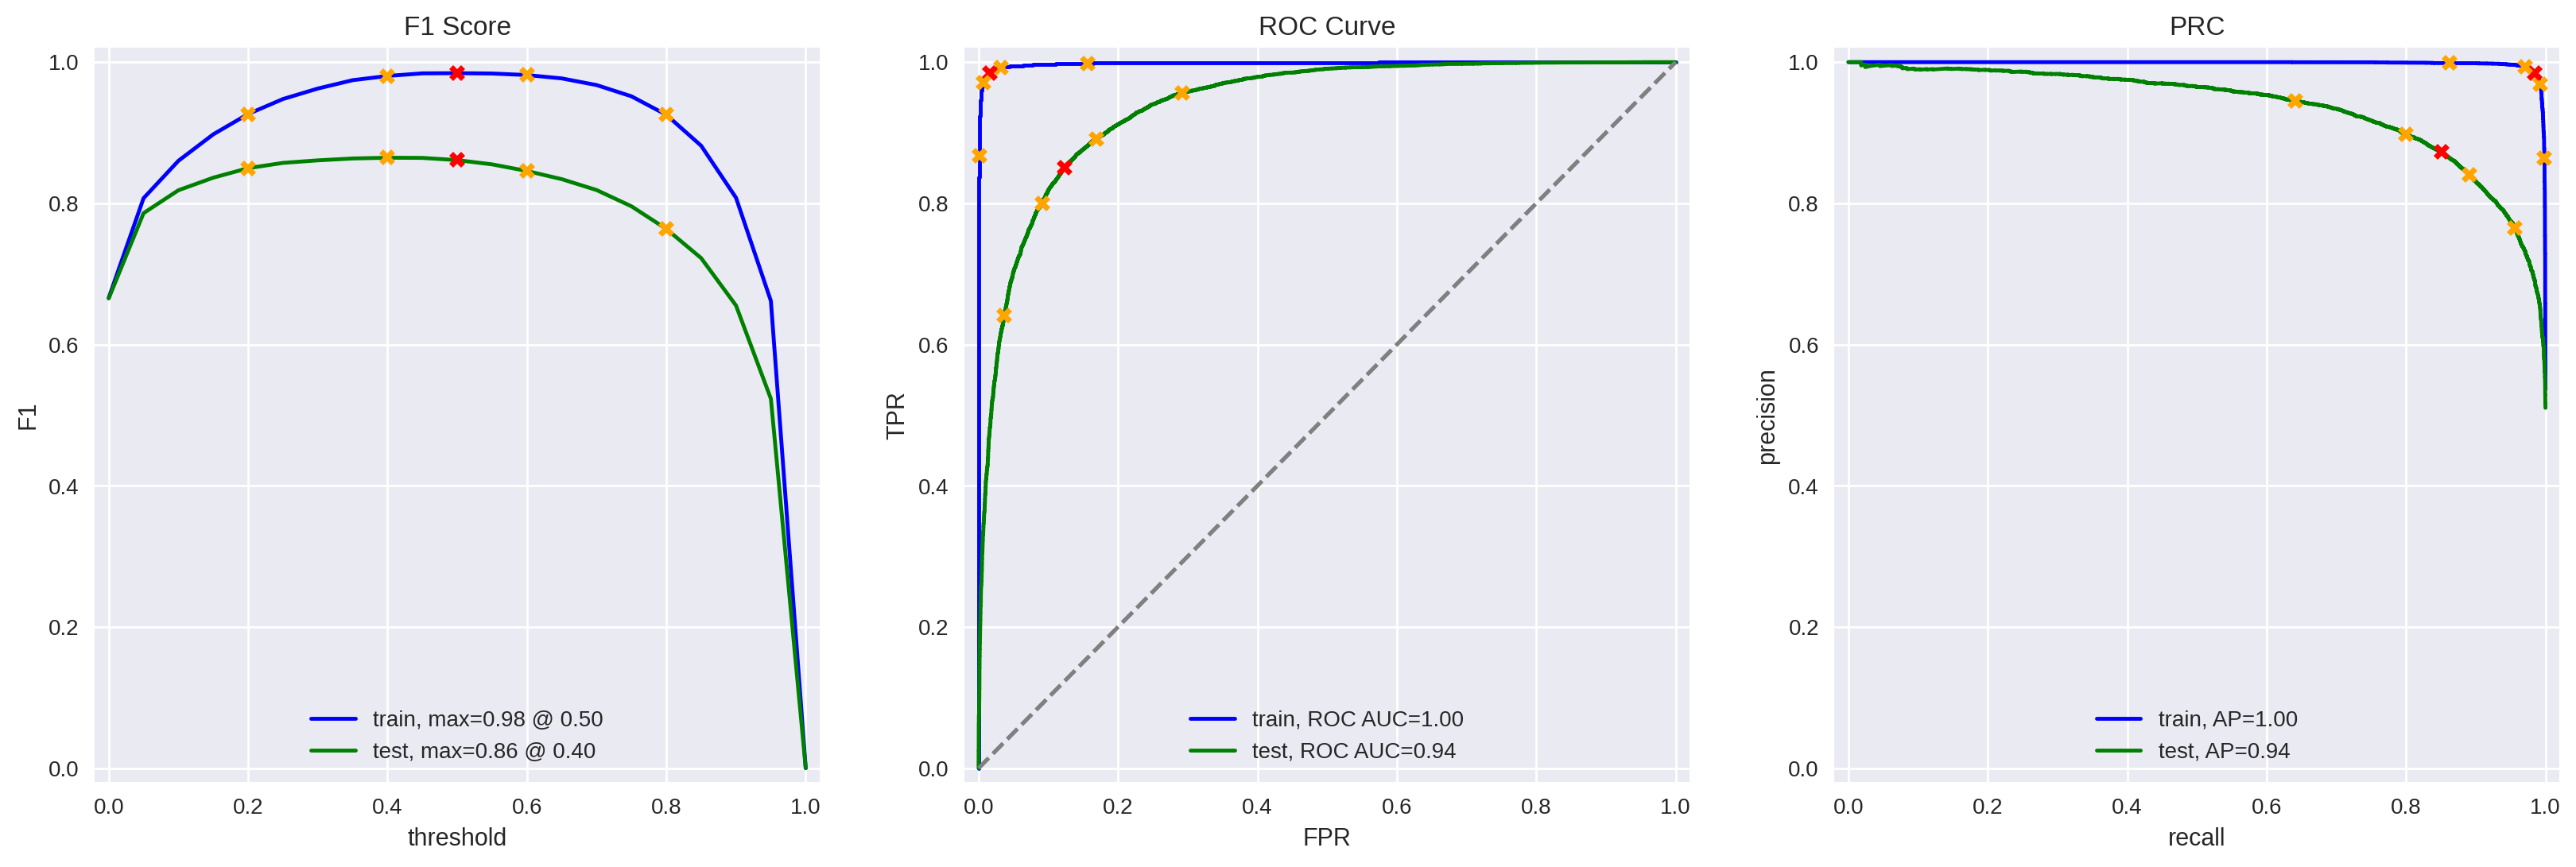

In [192]:
evaluate_model(model_3, X_train, y_train, X_test, y_test)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [193]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

In [194]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [195]:
# Preprocess with spaCy
#def text_preprocessing_spacy(text_series):
    #processed = []
    #for doc in nlp.pipe(text_series, batch_size=50):
        #tokens = [token.lemma_ for token in doc if token.is_alpha]
        #processed.append(" ".join(tokens))
    #return processed

In [196]:
def text_preprocessing_spacy(text):
    return text.apply(lambda row: " ".join(
        token.lemma_ for token in nlp(row) if not token.is_stop
    ))


In [197]:
df_reviews_train['review_lemmas_spacy'] = text_preprocessing_spacy(df_reviews_train['review_norm'])
df_reviews_test['review_lemmas_spacy'] = text_preprocessing_spacy(df_reviews_test['review_norm'])


In [198]:
# 2. TF-IDF Vectorization
tfidf4 = TfidfVectorizer(stop_words='english')
X_train = tfidf4.fit_transform(df_reviews_train['review_lemmas_spacy'])
X_test = tfidf4.transform(df_reviews_test['review_lemmas_spacy'])
y_train = df_reviews_train['pos']
y_test = df_reviews_test['pos']

In [199]:
# LGBMClassifier + GridSearchCV
lgbm = LGBMClassifier(random_state=0)

params = {
    'num_leaves': [31, 63],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

model_4 = GridSearchCV(lgbm, params, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
model_4.fit(X_train, y_train)


y_pred = model_4.predict(X_test)
print("Best LGBM parameters:", model_4.best_params_)
print("LGBM Accuracy:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best LGBM parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 63}
LGBM Accuracy: 0.865351921115267

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87     11803
           1       0.86      0.87      0.87     11732

    accuracy                           0.87     23535
   macro avg       0.87      0.87      0.87     23535
weighted avg       0.87      0.87      0.87     23535



          train  test
Accuracy   0.99  0.87
F1         0.99  0.87
APS        1.00  0.94
ROC AUC    1.00  0.94


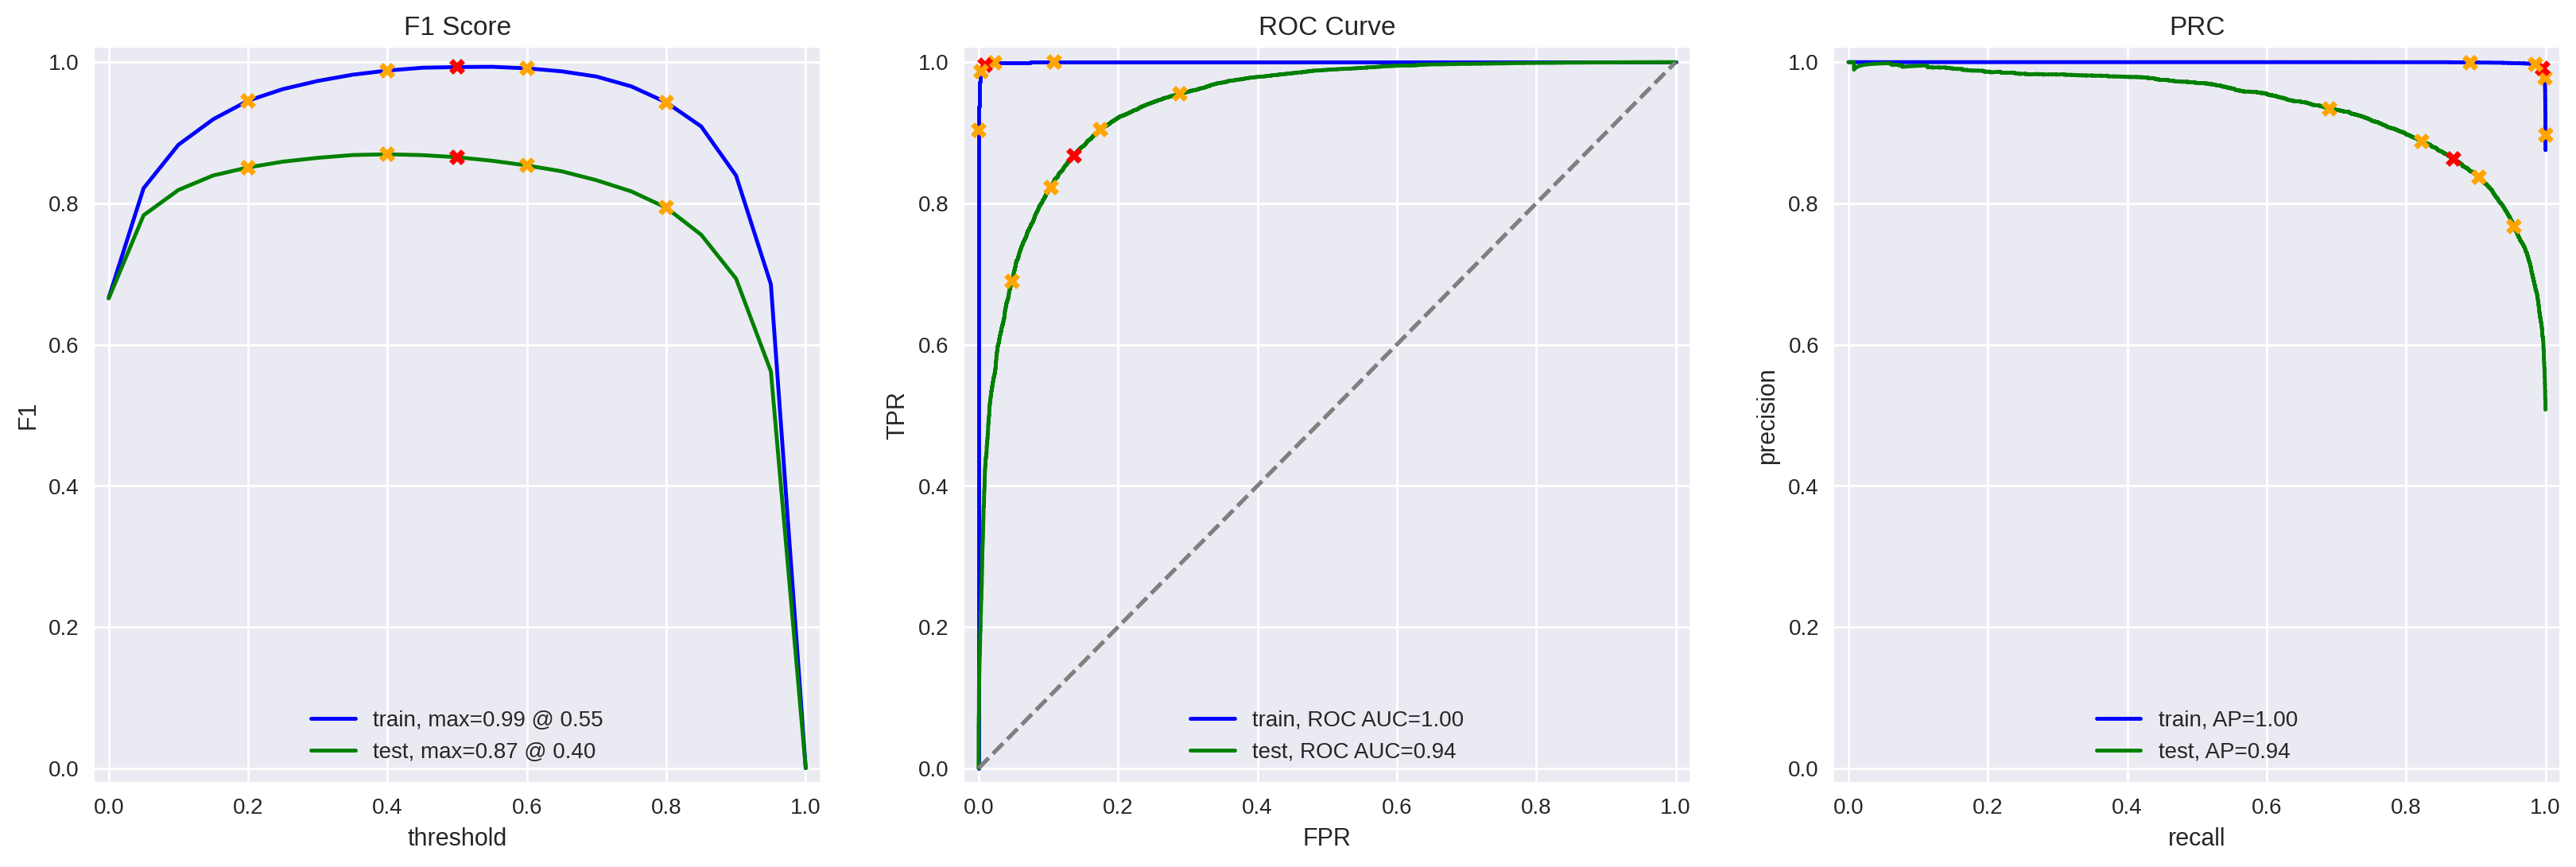

In [200]:
evaluate_model(model_4, X_train, y_train, X_test, y_test)

###  Model 9 - BERT

NOTE: This notebook includes an experimental BERT model using the "bert-base-uncased" pretrained language model.

Due to computational demands, BERT is only applied to a subset of 200 examples from both the train and test datasets.


In [201]:
import torch
import transformers

In [202]:
# Load BERT tokenizer and model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [203]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
print(f"Using device: {device}")


Using device: cpu


In [204]:
# Function to convert text to BERT embeddings
def BERT_text_to_embeddings(texts, max_length=128, batch_size=32):
    embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]

        # Tokenize and pad
        inputs = tokenizer(batch_texts.tolist(), padding=True, truncation=True,
                           max_length=max_length, return_tensors='pt')

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(embeddings)


In [205]:
# Sample 200 examples from each set
df_sample_train = df_reviews_train.sample(n=200, random_state=0)
df_sample_test = df_reviews_test.sample(n=200, random_state=1)

# Get raw text and labels
X_train_texts = df_sample_train['review_norm']
X_test_texts = df_sample_test['review_norm']
y_train = df_sample_train['pos']
y_test = df_sample_test['pos']

# Create BERT embeddings
X_train_bert = BERT_text_to_embeddings(X_train_texts)
X_test_bert = BERT_text_to_embeddings(X_test_texts)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [206]:
%%time 
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_bert, y_train)

# Predict
y_pred = lr.predict(X_test_bert)

# Evaluate
print("F1 score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


F1 score: 0.6739130434782609

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72       106
           1       0.69      0.66      0.67        94

    accuracy                           0.70       200
   macro avg       0.70      0.70      0.70       200
weighted avg       0.70      0.70      0.70       200

CPU times: user 53.1 ms, sys: 91.2 ms, total: 144 ms
Wall time: 167 ms


          train  test
Accuracy   1.00  0.70
F1         0.99  0.67
APS        1.00  0.80
ROC AUC    1.00  0.82


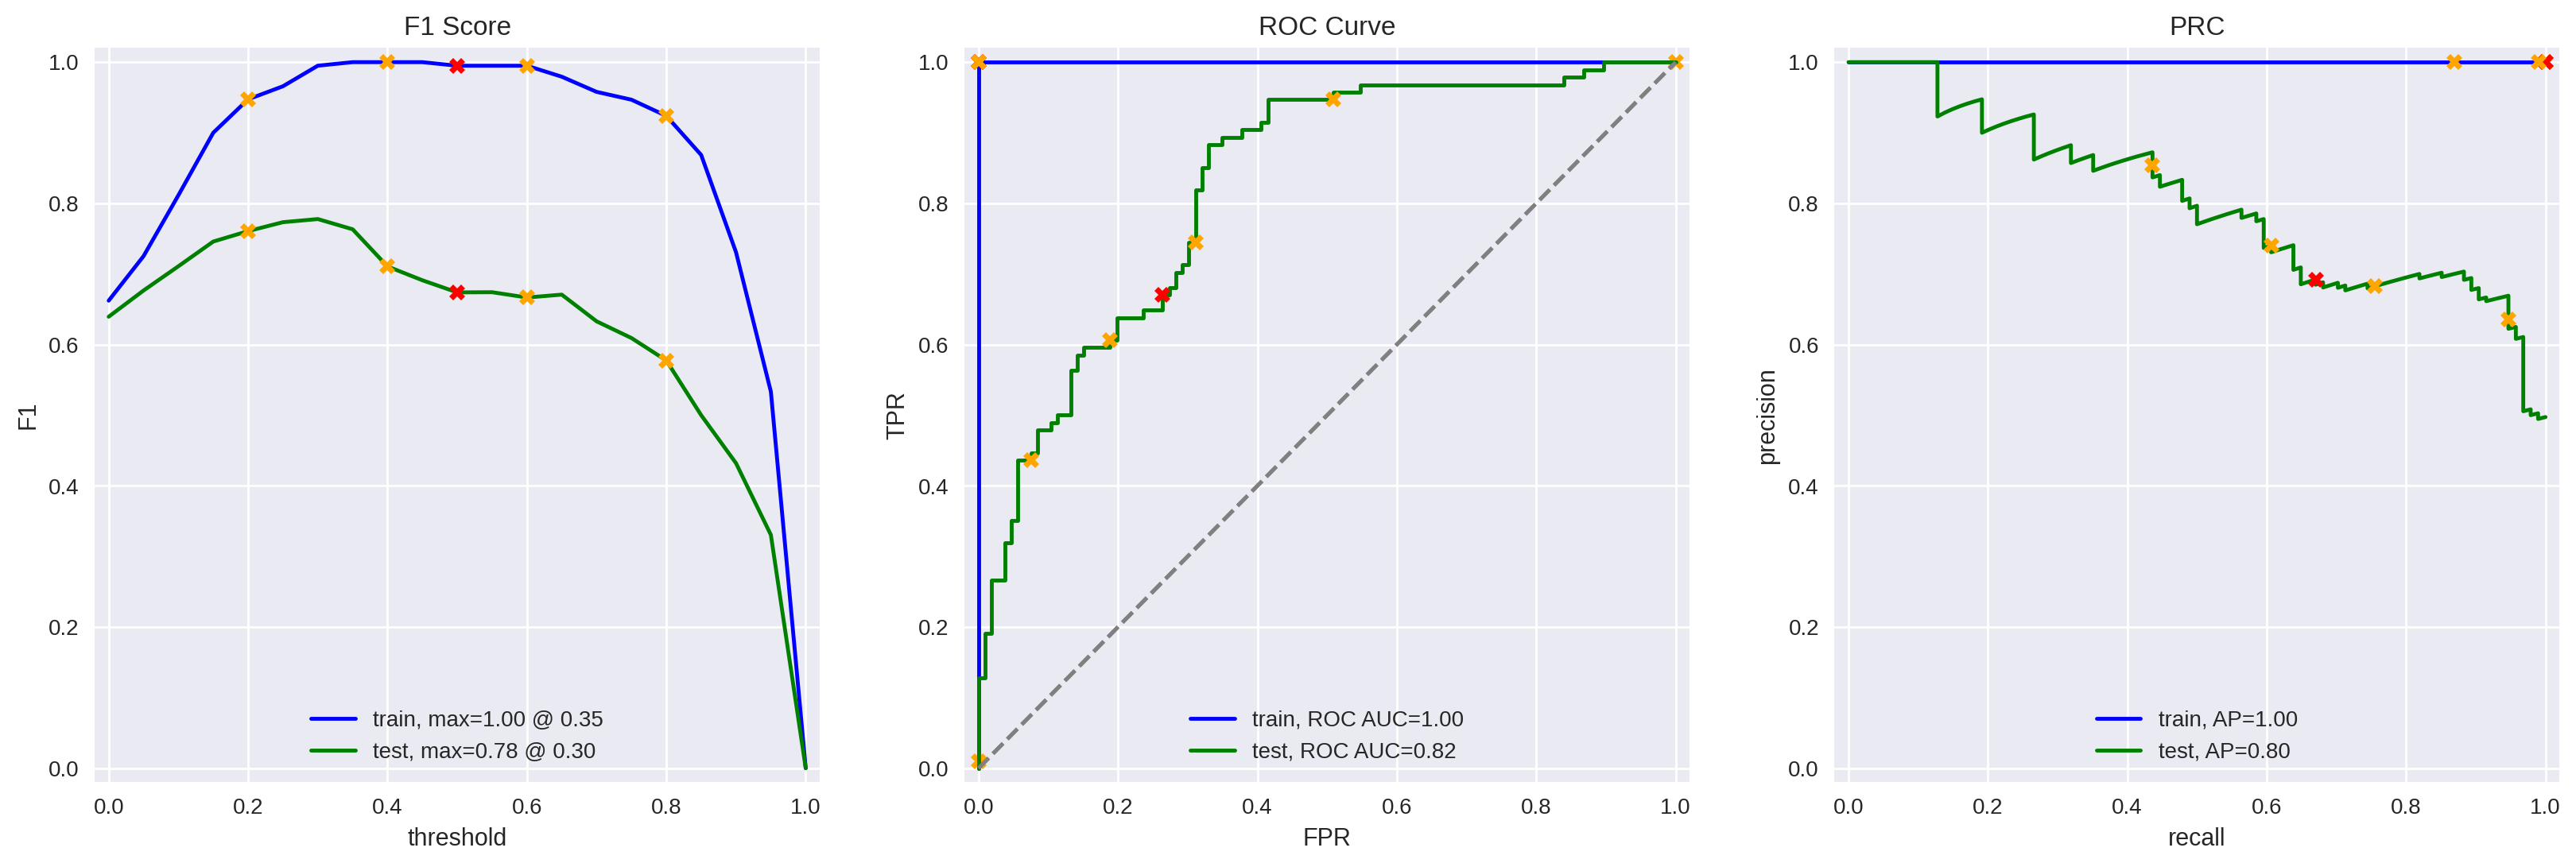

In [207]:
evaluate_model(lr, X_train_bert, y_train, X_test_bert, y_test)

In [208]:
np.savez_compressed('bert_embeddings.npz', 
                    train_features_bert=X_train_bert, 
                    test_features_bert=X_test_bert)


In [209]:
print(X_train_bert.shape)         
print(X_train_bert[0])            
#print(X_train_bert[0][:5])   


(200, 768)
[ 1.22041248e-01 -2.85063207e-01  1.90137088e-01  3.37703198e-01
  1.99999720e-01 -5.12298465e-01  1.58190038e-02  8.30406621e-02
  8.03601071e-02 -1.87757716e-01  4.86996412e-01  2.24083751e-01
 -2.22160481e-02  1.07756519e+00 -2.48422343e-02  4.14173275e-01
 -8.23346674e-02  5.88006198e-01  1.82634965e-01 -3.15341353e-01
 -1.44484550e-01 -2.71325916e-01  6.87755823e-01 -3.17419469e-01
  3.94545421e-02 -1.29359707e-01 -2.22956061e-01 -2.29910403e-01
  2.44272477e-03  1.44188777e-01  2.04377845e-01  2.54933268e-01
 -7.78754413e-01 -3.78442228e-01  9.00164247e-02 -7.37649798e-01
  1.01294011e-01 -1.58897638e-02  4.36813891e-01 -6.25159144e-02
 -1.22517049e-02 -1.90793514e-01  4.54968065e-01 -3.98315400e-01
 -2.03159064e-01 -1.75490044e-02 -3.29265285e+00 -2.08797172e-01
  2.62120545e-01  2.40936335e-02  4.61336195e-01 -3.60718995e-01
 -2.95817465e-01  1.64823100e-01  6.83644235e-01  8.01177919e-01
 -5.96434116e-01 -1.00021437e-01 -5.09869695e-01  2.01851696e-01
  5.75773418e-

In [210]:
# save embeddings
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [211]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])



In [212]:
# Model 1 required normalization and lemmatization
#  same normalization logic as for the main dataset
my_reviews['review_norm'] = normalize_text(my_reviews['review'])
my_reviews['review_lemmas'] = text_preprocessing_nltk(my_reviews['review_norm'])

my_reviews

,review,review_norm,review_lemmas
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,well i wa bored and felt asleep in the middle ...
2,I was really fascinated with the movie,i was really fascinated with the movie,i wa really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,even the actor looked really old and disintere...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...,i did n't expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,the movie had it upside and downside but i fee...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,launching on netflix wa a brave move i really ...


### Model 1

In [213]:
texts = my_reviews['review_lemmas']

#my_reviews['review_norm'] = normalize_text(my_reviews['review'])

my_reviews_pred_prob = model_1.predict_proba(tfidf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.05:  i did not simply like it not my kind of movie
0.01:  well i wa bored and felt asleep in the middle of the movie
0.60:  i wa really fascinated with the movie
0.02:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.09:  i did n't expect the reboot to be so good writer really cared about the source material
0.64:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.00:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.97:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod


### Model 3

In [216]:
#  same normalization logic as for the main dataset
my_reviews['review_norm'] = normalize_text(my_reviews['review'])
my_reviews['review_lemmas'] = text_preprocessing_spacy(my_reviews['review_norm'])

# cleaned text
texts = my_reviews['review_lemmas']

# predict probabilities
my_reviews_pred_prob = model_3.predict_proba(tfidf_3.transform(texts))[:, 1]

# predictions
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


0.09:  simply like kind movie
0.00:  bored feel asleep middle movie
0.59:  fascinated movie
0.02:  actor look old disintereste get pay movie soulless cash grab
0.05:  expect reboot good writer care source material
0.60:  movie upside downside feel like overall decent flick go
0.00:  rotten attempt comedy single joke land act annoying loud kid will like
0.98:  launch netflix brave appreciate able binge episode episode exciting intelligent new drama


### Model 4

In [ ]:
#  same normalization logic as for the main dataset
my_reviews['review_norm'] = normalize_text(my_reviews['review'])
my_reviews['review_lemmas'] = text_preprocessing_spacy(my_reviews['review_norm'])

texts = my_reviews['review_lemmas']

# Predict probabilities
my_reviews_pred_prob = model_4.predict_proba(tfidf4.transform(texts))[:, 1]

# Print predictions
for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')



### Model 9

In [ ]:
texts = my_reviews['review_']

my_reviews_features_9 = BERT_text_to_embeddings(texts)

my_reviews_pred_prob = lr.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

Although the BERT-based model achieves near-perfect performance on the training set, its generalization to new data is noticeably weaker, with a test F1 score of 0.67. In contrast, traditional models using NLTK or spaCy with TF-IDF features achieve consistently strong performance across both training and test sets, with test F1 scores around 0.86–0.87. 

Overall, traditional models offered strong generalization, while BERT may hold future potential with better scaling and tuning. BERT could be more powerful with larger data and fine-tuning.
